In [1]:
seed=42
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.decomposition import PCA
from classification_cross_validation import pipeline_cross_val
from performance_stratification import bootstrap_factors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
df = pd.read_pickle('vocadiab_females_dataset.pkl')

In [15]:
df[df['diabetes']==1]['gender'].value_counts()

0    162
Name: gender, dtype: int64

In [16]:
byols_embeddings = np.stack(df['byols_embeddings'].values)
y_diab = df['diabetes'].values

### Grid-Search fine tuning

In [17]:
seed=42
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = seed)
scaler = StandardScaler()

In [18]:
search_space = {'pca__n_components': [10, 30, 50, 100, None],
                'classifier': [LogisticRegression(solver='liblinear')],
                'classifier__C': [0.01, 0.1, 1.0, 10]}
                 
pca_model =  Pipeline([('scaler', scaler), ('pca', PCA(random_state=seed)), ('classifier', LogisticRegression())])

clf = GridSearchCV(pca_model, search_space, cv=kfold, verbose=False, scoring='accuracy', n_jobs=-1)
clf = clf.fit(byols_embeddings, y_diab)

lr_c = clf.best_params_['classifier__C']

clf.best_params_

{'classifier': LogisticRegression(C=0.1, solver='liblinear'),
 'classifier__C': 0.1,
 'pca__n_components': None}

In [21]:
search_space = {'pca__n_components': [10, 30, 50, 100, None],
                'classifier': [MLPClassifier(learning_rate_init = 0.0001, random_state=seed, max_iter = 1000, alpha=0.01)],
                'classifier__hidden_layer_sizes': [(8,), (32,), (128,), (512,)], #(128, 64), (256, 128,), (512, 128,)
                'classifier__activation': ['relu', 'tanh', 'logistic'],
                'classifier__solver': ['adam', 'lbfgs', 'sgd']}
                 
pca_model =  Pipeline([('scaler', scaler), ('pca', PCA(random_state=seed)), ('classifier', MLPClassifier(random_state=seed, max_iter=1000, alpha=0.01, batch_size=128, learning_rate_init=0.0001))])

clf = GridSearchCV(pca_model, search_space, cv=kfold, verbose=False, scoring='accuracy', n_jobs=-1)
clf = clf.fit(byols_embeddings, y_diab) 

mlp_hidden_layer = clf.best_params_['classifier__hidden_layer_sizes'] 
mlp_activation = clf.best_params_['classifier__activation']
mlp_solver = clf.best_params_['classifier__solver']
#mlp_learning_rate = clf.best_params_['classifier__learning_rate_init']

clf.best_params_

{'classifier': MLPClassifier(alpha=0.01, hidden_layer_sizes=(512,), learning_rate_init=0.0001,
               max_iter=1000, random_state=42, solver='lbfgs'),
 'classifier__activation': 'relu',
 'classifier__hidden_layer_sizes': (512,),
 'classifier__solver': 'lbfgs',
 'pca__n_components': None}

In [22]:
search_space = {'pca__n_components': [10, 30, 50, 100, None],
                'classifier': [SVC(kernel='rbf', random_state=42)],
                 'classifier__C': [1e4, 1e5, 1e6],
                 'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3]}
                 
pca_model =  Pipeline([('scaler', scaler), ('pca', PCA(random_state=seed)), ('classifier', SVC(kernel='rbf', random_state=42))])

clf = GridSearchCV(pca_model, search_space, cv=kfold, verbose=False, scoring='accuracy', n_jobs=-1)
clf = clf.fit(byols_embeddings, y_diab)

svc_c = clf.best_params_['classifier__C']
svc_g = clf.best_params_['classifier__gamma']

clf.best_params_

{'classifier': SVC(C=10000.0, gamma=0.0001, random_state=42),
 'classifier__C': 10000.0,
 'classifier__gamma': 0.0001,
 'pca__n_components': 100}

In [23]:
# Model building to train
names = ['Logistic Regression', 'MLP Classifier', 'SVM rbf']
Classifiers = [LogisticRegression(solver='liblinear', C=lr_c), 
               MLPClassifier(random_state=seed, hidden_layer_sizes=mlp_hidden_layer, activation=mlp_activation, solver=mlp_solver, learning_rate_init=0.0001, max_iter=1000, alpha=0.01 , batch_size=128),
               SVC(kernel='rbf', C=svc_c, gamma=svc_g, probability=True, random_state=42)] 

### Performance evaluation

#### Females

In [24]:
pipeline_cross_val(names, Classifiers, byols_embeddings, y_diab, reduction = 'PCA', n_components=None, kfold = kfold)

,Classifier,accuracy,balanced_accuracy,Precision,Recall,F1,AUC,Specificity
0,Logistic Regression,0.67 (0.04),0.67 (0.04),0.68 (0.04),0.65 (0.11),0.66 (0.06),0.70 (0.06),0.68 (0.08)
1,MLP Classifier,0.67 (0.04),0.68 (0.04),0.66 (0.03),0.67 (0.11),0.66 (0.06),0.72 (0.07),0.66 (0.04)
2,SVM rbf,0.66 (0.04),0.66 (0.04),0.66 (0.03),0.67 (0.11),0.66 (0.06),0.71 (0.05),0.65 (0.07)


#### Males

In [11]:
pipeline_cross_val(names, Classifiers, byols_embeddings, y_diab, reduction = 'PCA', n_components=100, kfold = kfold)

,Classifier,accuracy,balanced_accuracy,Precision,Recall,F1,AUC,Specificity
0,Logistic Regression,0.69 (0.04),0.69 (0.04),0.68 (0.05),0.72 (0.03),0.70 (0.03),0.73 (0.06),0.66 (0.07)
1,MLP Classifier,0.71 (0.02),0.71 (0.02),0.71 (0.01),0.73 (0.03),0.72 (0.02),0.75 (0.05),0.70 (0.02)
2,SVM rbf,0.70 (0.04),0.70 (0.04),0.68 (0.05),0.76 (0.03),0.72 (0.03),0.78 (0.05),0.64 (0.08)


### Agreement with ADA risk score

In [26]:
#BYOL-S: ENG 160302023 T2D, Audios type1, without age matched female
from sklearn.model_selection import cross_val_predict

new_model =  Pipeline([('scaler', scaler), ('reduction', PCA(random_state=42, n_components=None)), ('model', MLPClassifier(random_state=seed, hidden_layer_sizes=mlp_hidden_layer, activation=mlp_activation, solver=mlp_solver, learning_rate_init=0.0001, max_iter=1000, alpha=0.01 , batch_size=128))])
predictions = cross_val_predict(new_model, byols_embeddings, y_diab, cv=kfold, method='predict_proba')
df['predictions'] = predictions[:,1:]

In [18]:
#BYOL-S: ENG 160302023 T2D, Audios type1, without age matched male
from sklearn.model_selection import cross_val_predict

new_model =  Pipeline([('scaler', scaler), ('reduction', PCA(random_state=42, n_components=100)), ('model', MLPClassifier(random_state=seed, hidden_layer_sizes=mlp_hidden_layer, activation=mlp_activation, solver=mlp_solver, learning_rate_init=0.0001, max_iter=1000, alpha=0.01 , batch_size=128))])
predictions = cross_val_predict(new_model, byols_embeddings, y_diab, cv=kfold, method='predict_proba')
df['predictions'] = predictions[:,1:]

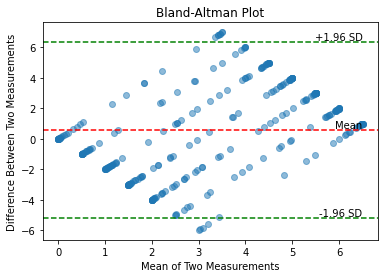

In [31]:
#female
data1 = ((df['predictions'].values)*7)
data2= df['ADA_score'].values
means = (data1 + data2) / 2
differences = data1 - data2
mean_difference = np.mean(differences)
std_difference = np.std(differences)
# Compute limits of agreement
loa1 = mean_difference - 1.96 * std_difference
loa2 = mean_difference + 1.96 * std_difference

# Create Bland-Altman plot
plt.scatter(means, differences, alpha=0.5)
plt.axhline(mean_difference, color='red', linestyle='--')
plt.axhline(loa1, color='green', linestyle='--')
plt.axhline(loa2, color='green', linestyle='--')
plt.text(max(means), mean_difference, 'Mean', va='bottom', ha='right')
plt.text(max(means), loa1, '-1.96 SD', va='bottom', ha='right')
plt.text(max(means), loa2, '+1.96 SD', va='bottom', ha='right')

plt.xlabel('Mean of Two Measurements')
plt.ylabel('Difference Between Two Measurements')
plt.title('Bland-Altman Plot')
plt.show()

In [32]:
#female
# Percentage of observations within LoA
within_loa = np.sum((differences <= loa2) & (differences >= loa1))
percentage_within_loa = (within_loa / len(differences)) * 100

print("Mean Difference:", mean_difference)
print("Upper Limit of Agreement:", loa2)
print("Lower Limit of Agreement:", loa1)
print("Percentage within Limits of Agreement:", percentage_within_loa)

Mean Difference: 0.5768015509768413
Upper Limit of Agreement: 6.344701818471377
Lower Limit of Agreement: -5.191098716517693
Percentage within Limits of Agreement: 96.59442724458205


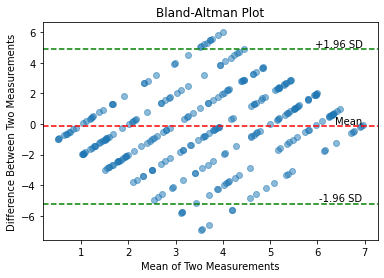

In [19]:
#male
data1 = ((df['predictions'].values)*7)
data2= df['ADA_score'].values
means = (data1 + data2) / 2
differences = data1 - data2
mean_difference = np.mean(differences)
std_difference = np.std(differences)
# Compute limits of agreement
loa1 = mean_difference - 1.96 * std_difference
loa2 = mean_difference + 1.96 * std_difference

# Create Bland-Altman plot
plt.scatter(means, differences, alpha=0.5)
plt.axhline(mean_difference, color='red', linestyle='--')
plt.axhline(loa1, color='green', linestyle='--')
plt.axhline(loa2, color='green', linestyle='--')
plt.text(max(means), mean_difference, 'Mean', va='bottom', ha='right')
plt.text(max(means), loa1, '-1.96 SD', va='bottom', ha='right')
plt.text(max(means), loa2, '+1.96 SD', va='bottom', ha='right')

plt.xlabel('Mean of Two Measurements')
plt.ylabel('Difference Between Two Measurements')
plt.title('Bland-Altman Plot')
plt.show()

In [20]:
#male
# Percentage of observations within LoA
within_loa = np.sum((differences <= loa2) & (differences >= loa1))
percentage_within_loa = (within_loa / len(differences)) * 100

print("Mean Difference:", mean_difference)
print("Upper Limit of Agreement:", loa2)
print("Lower Limit of Agreement:", loa1)
print("Percentage within Limits of Agreement:", percentage_within_loa)

Mean Difference: -0.15138039974049783
Upper Limit of Agreement: 4.893547777634846
Lower Limit of Agreement: -5.196308577115842
Percentage within Limits of Agreement: 93.66197183098592


### Performance stratification

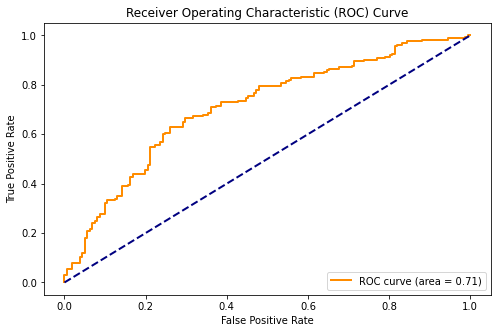

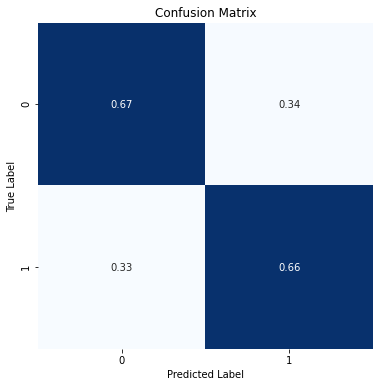

In [33]:
#Females
#Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_diab, df['predictions'])
roc_auc = auc(fpr, tpr)

#Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Compute the confusion matrix
binary_predictions = np.where(df['predictions'] > 0.5, 1, 0)
cm = confusion_matrix(y_diab, binary_predictions, normalize='pred')


#Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

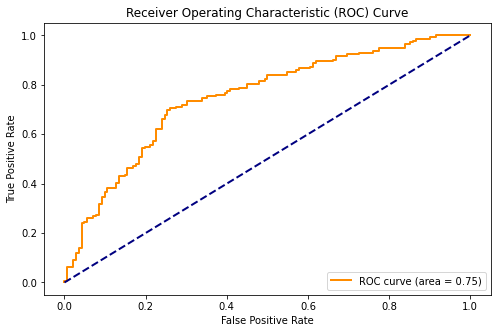

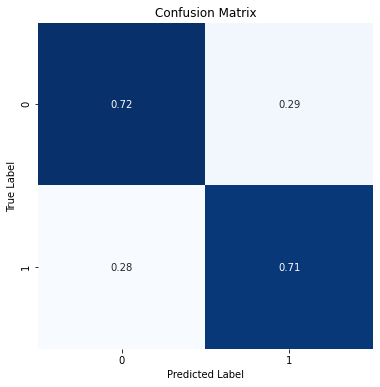

In [22]:
#Males
#Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_diab, df['predictions'])
roc_auc = auc(fpr, tpr)

#Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Compute the confusion matrix
binary_predictions = np.where(df['predictions'] > 0.5, 1, 0)
cm = confusion_matrix(y_diab, binary_predictions, normalize='pred')


#Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
group_names = [0, 1]

# Create a new column with the age categories
df['BMI categories'] = pd.cut(df['bmi'], bins = [0, 25, float('inf')], labels=group_names)

In [35]:
group_names = [0, 1]

# Create a new column with the age categories
df['Age categories (year)'] = pd.cut(df['age'], bins = [0, 60, float('inf')], labels=group_names)

In [36]:
df['predictions_binary']=binary_predictions

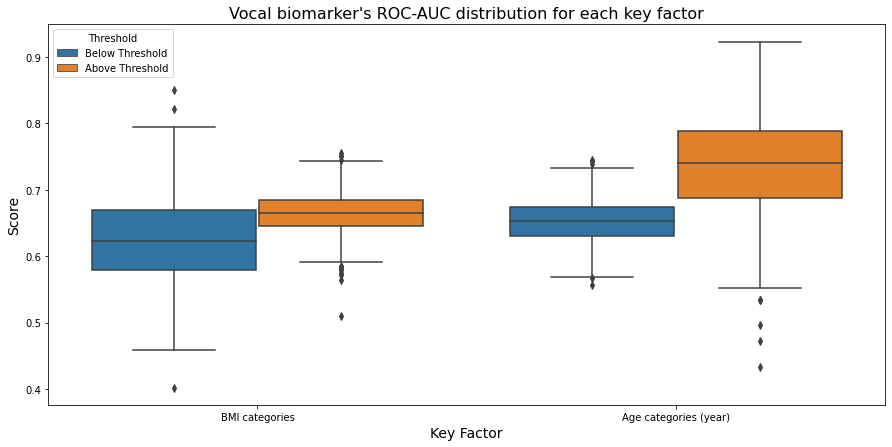

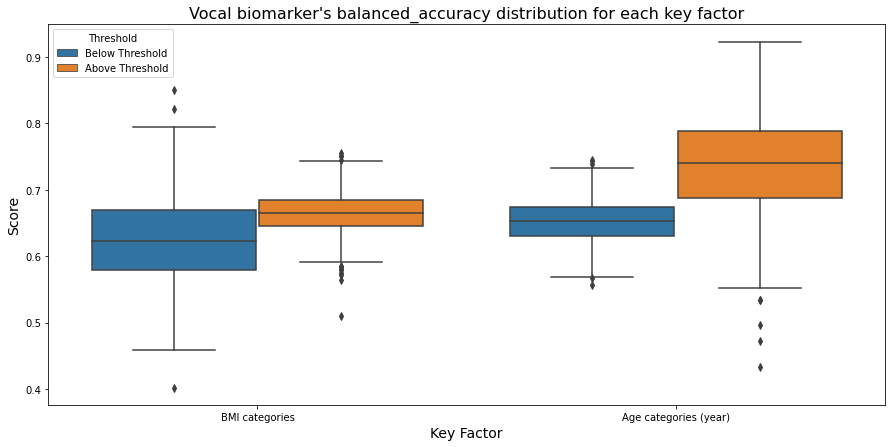

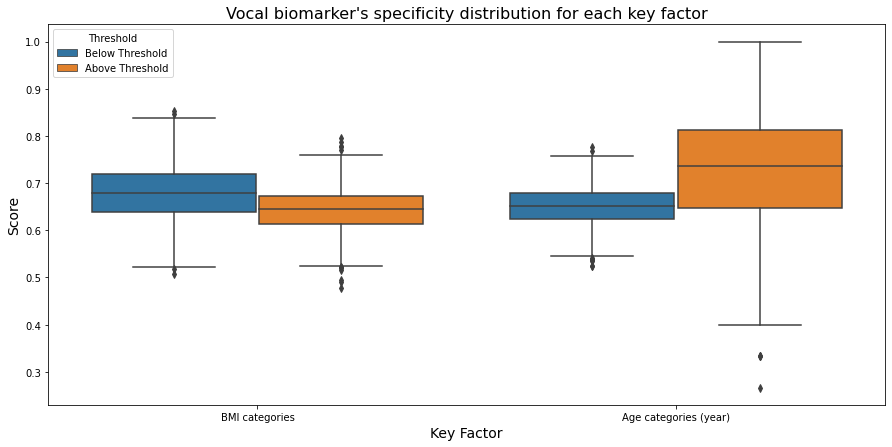

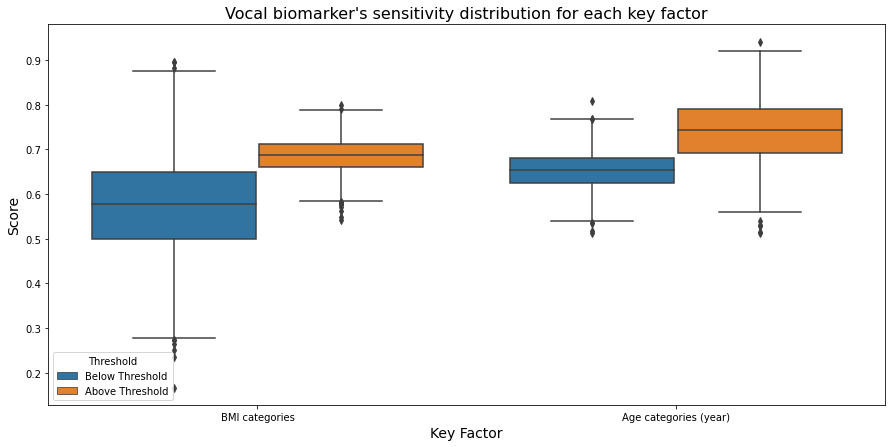

,Key factor,Metric,Above Threshold,Below Threshold,Statistic,adjusted P-value
0,BMI categories,ROC-AUC,0.66 (0.03),0.63 (0.07),709127.5,0.0
1,BMI categories,balanced_accuracy,0.66 (0.03),0.63 (0.07),709127.0,0.0
2,BMI categories,specificity,0.64 (0.05),0.68 (0.06),321882.5,0.0
3,BMI categories,sensitivity,0.69 (0.04),0.57 (0.12),822571.0,0.0
4,Age categories (year),ROC-AUC,0.74 (0.07),0.65 (0.03),858255.0,0.0
5,Age categories (year),balanced_accuracy,0.74 (0.07),0.65 (0.03),858251.5,0.0
6,Age categories (year),specificity,0.73 (0.12),0.65 (0.04),744069.5,0.0
7,Age categories (year),sensitivity,0.74 (0.08),0.65 (0.04),843630.5,0.0


In [37]:
#Females
comorbidities = ['BMI categories', 'Age categories (year)']
bootstrap_results, ttest_results = bootstrap_factors(df, comorbidities, plot=True)
ttest_results

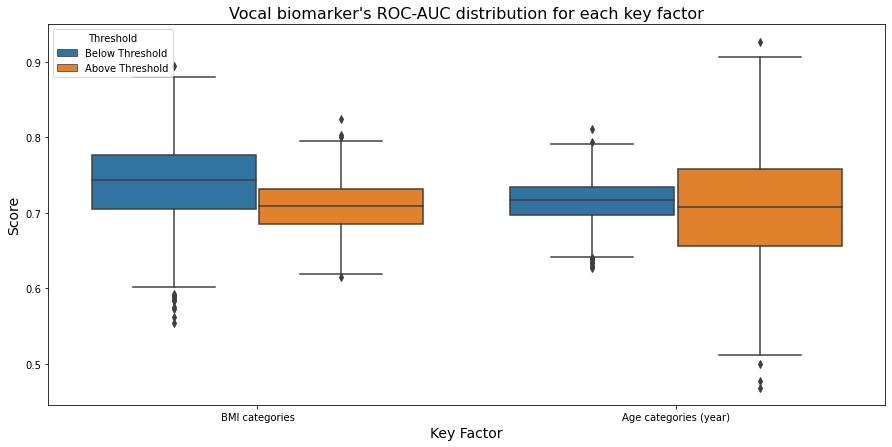

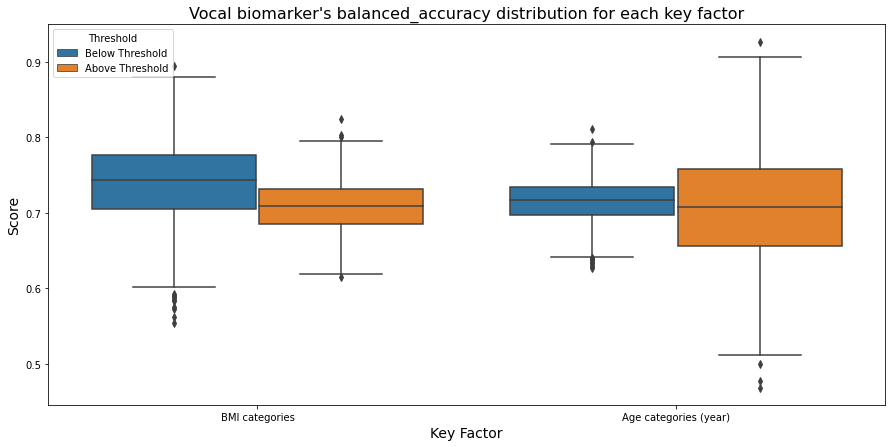

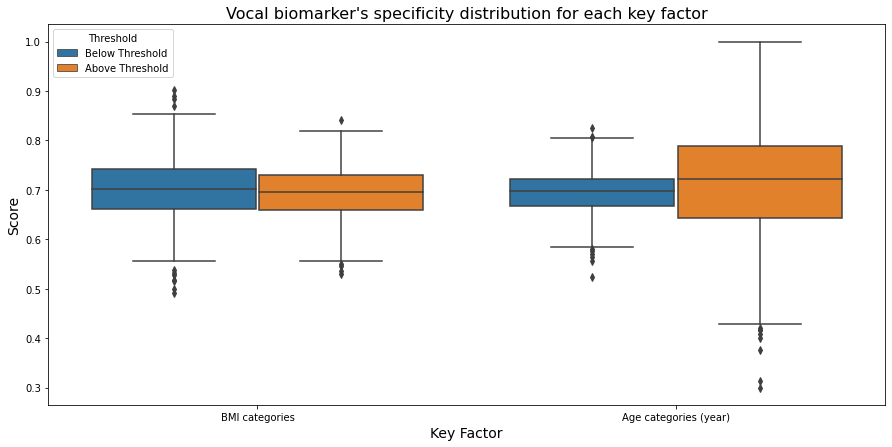

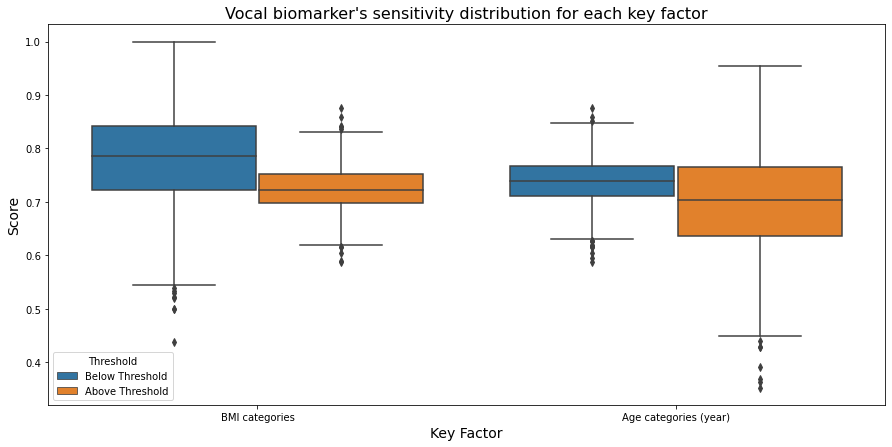

,Key factor,Metric,Above Threshold,Below Threshold,Statistic,adjusted P-value
0,BMI categories,ROC-AUC,0.71 (0.03),0.74 (0.05),297237.0,0.0
1,BMI categories,balanced_accuracy,0.71 (0.03),0.74 (0.05),297240.0,0.0
2,BMI categories,specificity,0.69 (0.05),0.70 (0.06),459132.0,0.012413
3,BMI categories,sensitivity,0.72 (0.04),0.78 (0.09),277923.0,0.0
4,Age categories (year),ROC-AUC,0.71 (0.08),0.72 (0.03),459281.0,0.012917
5,Age categories (year),balanced_accuracy,0.71 (0.08),0.72 (0.03),459270.0,0.012879
6,Age categories (year),specificity,0.71 (0.11),0.69 (0.04),582375.5,0.0
7,Age categories (year),sensitivity,0.70 (0.10),0.74 (0.04),365174.0,0.0


In [42]:
#Males
comorbidities = ['BMI categories', 'Age categories (year)']
bootstrap_results, ttest_results = bootstrap_factors(df, comorbidities, plot=True)
ttest_results